In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from chaosmagpy.model_utils import synth_values
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from typing import List, Tuple
from tqdm import tqdm
import torch
from torch import nn
from mpl_toolkits.basemap import Basemap

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [548]:
def mfield(year: int, loc: Tuple[np.ndarray, np.ndarray]) -> List[np.ndarray]:
    coeff = pd.read_excel('igrf13coeffs.xls', header=3)[int(year)].to_numpy()
    radius = 6371.2
    lat, lon = loc
    theta = 90 - lat
    phi = lon
    B_r, B_theta, B_phi = synth_values(coeff, radius, theta, phi, grid = isinstance(loc[0], np.ndarray))
    V = (B_r**2 + B_theta**2 + B_phi**2)**0.5
    return V, B_r, B_theta, B_phi

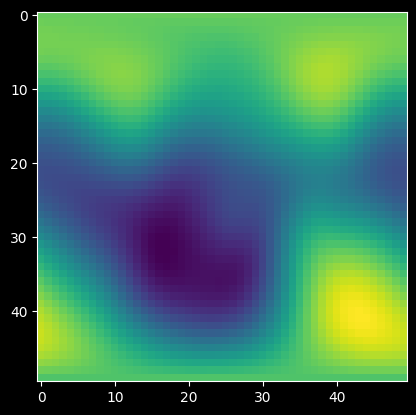

In [138]:
for i in range(1900,2020,5):
    plt.imshow(mfield(i))
    plt.show()
    clear_output(wait=True)

In [490]:
obs = pd.read_table('results (1).tsv')[['year','lat','lon','inten','inc','decl']].dropna().to_numpy()

In [549]:
check = lambda year: {(i[1], i[2]):(i[3], mfield(year, (i[1], i[2]))[0]) for i in obs if i[0]==year}
# catalog = {(i[1], i[2]):(i[3], field(i[1], i[2]) for i in obs if i[0]==year}
# check(1900)

In [270]:
lat = np.linspace(90, -90, 1000)
lon = np.linspace(-180, 180, 1500)
# grid_obs = np.zeros((1500,1000))
# grid_gauss = np.zeros((1500,1000))
# grid_diff = np.zeros((1500,1000))
# dic = check(1900)
# for i,v in enumerate(tqdm(lat)):
#     for j,h in enumerate(lon):
#         for loc in dic.keys():
#             _v, _h = loc
#             if v-_v + h-_h > 1.5:
#                 grid_obs[j,i] = dic[loc][0]
#                 grid_gauss[j,i] = dic[loc][1]
#                 grid_diff[j,i] = dic[loc][0] - dic[loc][1]

In [287]:
def data(year):
    LON, LAT = np.meshgrid(lon,lat)
    plt.contourf(LON, LAT, mfield(5*(year//5),(lat,lon))[0])
    lat_obs, lon_obs = [], []
    dic = check(year)
    if len(dic)!=0:
        for _lat, _lon in check(year).keys():
            lat_obs.append(_lat)
            lon_obs.append(_lon)
        plt.scatter(lon_obs, lat_obs)
    plt.xlim(-180,180)
    plt.ylim(-90,90)

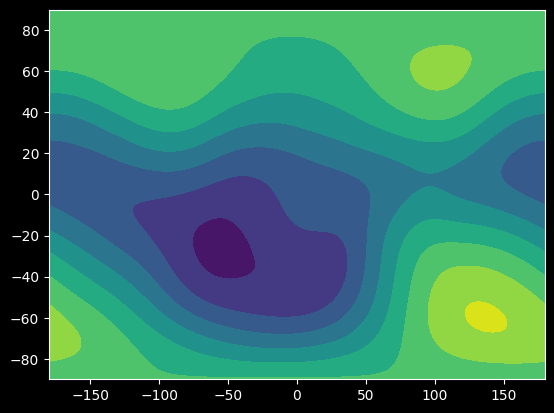

In [288]:
for y in range(1900,2020,1):
    data(y)
    plt.show()
    clear_output(wait=True)

In [1260]:
class MDP:

    @torch.no_grad()
    def __init__(self, year) -> None:
        self.coeff = pd.read_excel('igrf13coeffs.xls', header=3)[5*(year//5)].to_numpy()
        self.obs = pd.read_table('results (1).tsv')[['year','lat','lon','inten','inc','decl']].dropna().to_numpy()
        self.mean_trend = np.mean(np.array([pd.read_excel('igrf13coeffs.xls', header=3)[y].to_numpy() for y in range(1900,2020,5)]), axis=0)
        self.decay = abs(self.mean_trend)/10
        self.catalog = {(i[1], i[2]):(i[3], self.field(i[1], i[2])[0]) for i in self.obs if i[0]==year}
        self.var_catalog = lambda coeff: {(i[1], i[2]):(i[3], self.field(i[1], i[2], coeff)[0]) for i in self.obs if i[0]==year}
        self.reset_flag = False

    def reset(self) -> None:
        self.current_state = self.coeff
        self.reset_flag = True

    def field(self, lat: np.ndarray | float, lon: np.ndarray | float, coeff = None) -> List[np.ndarray | float]:
        if coeff is None:
            coeff = self.coeff
        radius = 6371.2
        theta = 90 - lat   # Co-latitude
        phi = lon
        B_r, B_theta, B_phi = synth_values(coeff, radius, theta, phi, grid = not isinstance(lat, float))
        F = (B_r**2 + B_theta**2 + B_phi**2)**0.5
        return F, B_r, B_theta, B_phi

    def contour_plot(self, lat_spacing: int, lon_spacing: int, coeff = None) -> List[np.ndarray]: # unpack in plt.contour
        if coeff is None:
            coeff = self.coeff
        lat = np.linspace(90, -90, lat_spacing)
        lon = np.linspace(-180, 180, lon_spacing)
        return np.meshgrid(lon, lat) + [self.field(lat, lon, coeff)[0]]

    def step(self, action: np.ndarray) -> tuple:
        assert self.reset_flag, 'Stepping without resetting environment'
        init_state = self.current_state
        self.current_state = self.current_state + action
        reward = self.reward_fun(self.current_state, init_state, action)
        return self.current_state, reward

    def reward_fun(self, s_, s, a):
        alpha = 100
        beta = 0
        gamma = 0
        R1 = sum([(self.field(lat,lon,coeff=s_)[0] - F_obs)**2 for (lat,lon),(F_obs, F_g) in self.catalog.items()]) \
             / sum([(F_g - F_obs)**2 for (lat,lon),(F_obs, F_g) in self.catalog.items()]) if len(self.catalog)!=0 else 0
        R2 = 1e-4*np.mean(abs(self.contour_plot(100,150,coeff=s_)[2] - self.contour_plot(100,150)[2]))
        R3 = abs(sum(abs(s_[120:])-60))
        return -alpha * R1 - beta * R2 - gamma * R3

In [1261]:
class Trajectory(MDP):

    def __init__(self, year):
        super().__init__(year)

    @torch.no_grad()
    def get_traj(self, timesteps, ep_len, policy):
        self.reset()
        traj = [[]]
        for i in tqdm(range(ep_len)):
            for j in range(timesteps):
                state = self.current_state
                action = policy.sample(state, self.decay).detach().numpy()
                s,r = self.step(action)
                traj[i].append((state, action, r, s))
            traj.append([])
        return traj

In [1262]:
class Policy(nn.Module):

    lin_block = lambda self,i,o: nn.Sequential(nn.Linear(i,o), nn.ReLU())
    
    def __init__(self, state_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = state_dim
        self.l1 = nn.Sequential(self.lin_block(state_dim, 500),
                               self.lin_block(500, 1000),
                               self.lin_block(1000, 1000),
                               self.lin_block(1000, 500),
                               self.lin_block(500, 200))
        self.mu = nn.Sequential(nn.Linear(200,self.action_dim), nn.Tanh())
        self.log_std = nn.Sequential(nn.Linear(200,self.action_dim), nn.Tanh())

    def forward(self, x, decay=None):
        out = self.l1(x)
        mu = self.mu(out)
        log_std = self.log_std(out)
        if decay is not None:
            mu = mu * torch.tensor(decay).float()
            # log_std = log_std * torch.tensor([min(1.5,max(-1.5,i)) for i in torch.log(torch.tensor(decay).float()*0.05)]).float()
            log_std = log_std + torch.log(0.1*abs(mu))
        return mu, torch.exp(log_std)

    def sample(self, state, decay=None):
        state = torch.tensor(state).float()
        mu, std = self.forward(state, decay)
        action = torch.normal(mu, std)
        return action

In [1263]:
def train_step(batch, policy, optimizer):
    optimizer.zero_grad()
    J = 0
    for t,ep in enumerate(batch):
        ep_sum = 0
        baseline = 0
        for i,(s,a,r,s_) in enumerate(ep):
            s,a = torch.tensor(s).float(), torch.tensor(a).float()
            u,std = policy(s, trj.decay)
            ep_sum += sum(-0.5*((a-u)/std)**2 - torch.log(std) - 0.5*torch.log(2*torch.tensor(np.pi))) * \
                      torch.tensor(sum([r*0.5**j for j,(s,a,r,s_) in enumerate(ep[i:])]) - baseline)
        J = J + (1/(t+1))*(ep_sum/(i+1) - J)
    J *= -1
    J.backward()
    with torch.no_grad():
        optimizer.step()
        return -J.item()

In [1264]:
trj = Trajectory(1915)
trj.reset()
policy = Policy(len(trj.current_state))
optimizer = torch.optim.Adam(policy.parameters(), lr=0.003)
iterations = 1
epochs = 15

In [1265]:
for epoch in range(epochs):
    L = 0
    for i in range(iterations):
        batch = trj.get_traj(2,20,policy)
        L += train_step(batch, policy, optimizer)
    print(f'Cost: {L/(i+1)}')

100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


Cost: -335497.73922933236


100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


Cost: -427474.3825683556


100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


Cost: -365821.0100925188


100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


Cost: -334407.2696460496


100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


Cost: -429531.75008498173


 35%|███████████████▍                            | 7/20 [00:06<00:12,  1.05it/s]


KeyboardInterrupt: 

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


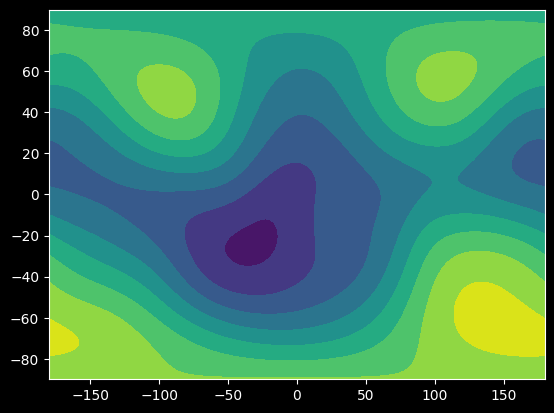

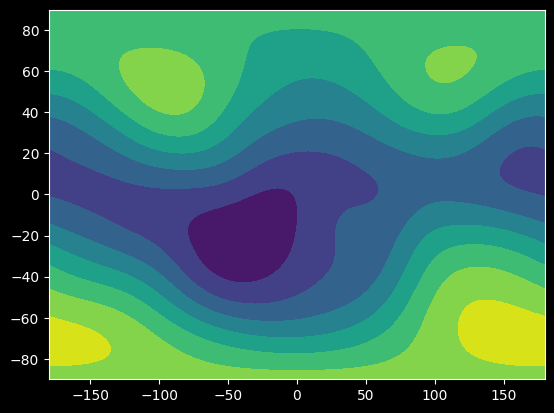

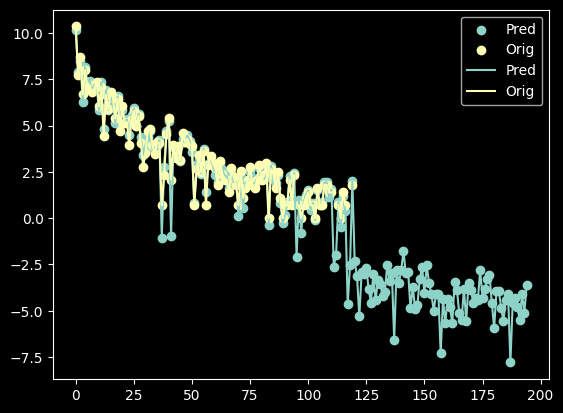

In [1299]:
trj = Trajectory(1915)
trj.reset()
c = trj.get_traj(2,1,policy)[0][-1][-1]
plt.contourf(*trj.contour_plot(1000,1500,c))
plt.show()
plt.contourf(*trj.contour_plot(1000,1500))
plt.show()
plt.scatter(np.arange(0,195,1),np.log(abs(c)), label='Pred')
plt.scatter(np.arange(0,195,1),np.log(abs(trj.coeff)), label='Orig')
plt.plot(np.log(abs(c)), label='Pred')
plt.plot(np.log(abs(trj.coeff)), label='Orig')
plt.legend()

In [1271]:
set(trj.obs[:,0])

{1900.0,
 1901.0,
 1902.0,
 1903.0,
 1904.0,
 1905.0,
 1906.0,
 1907.0,
 1908.0,
 1909.0,
 1910.0,
 1911.0,
 1912.0,
 1913.0,
 1914.0,
 1915.0,
 1916.0,
 1917.0,
 1918.0,
 1919.0,
 1920.0,
 1921.0,
 1922.0,
 1923.0,
 1924.0,
 1925.0,
 1926.0,
 1927.0,
 1928.0,
 1929.0,
 1930.0,
 1945.0,
 1946.0,
 1947.0,
 1948.0,
 1950.0,
 1955.0,
 1959.0,
 1960.0,
 1971.0,
 1972.0,
 1977.0,
 1981.0,
 1982.0,
 1984.0,
 2003.0}

In [1290]:
locs = [f'{i}' for i in trj.catalog.keys()][:10]
diffs = {'pred':[abs(i-j) for i,j in trj.var_catalog(c).values()][:10],
 'gauss':[abs(i-j) for i,j in trj.catalog.values()][:10]}

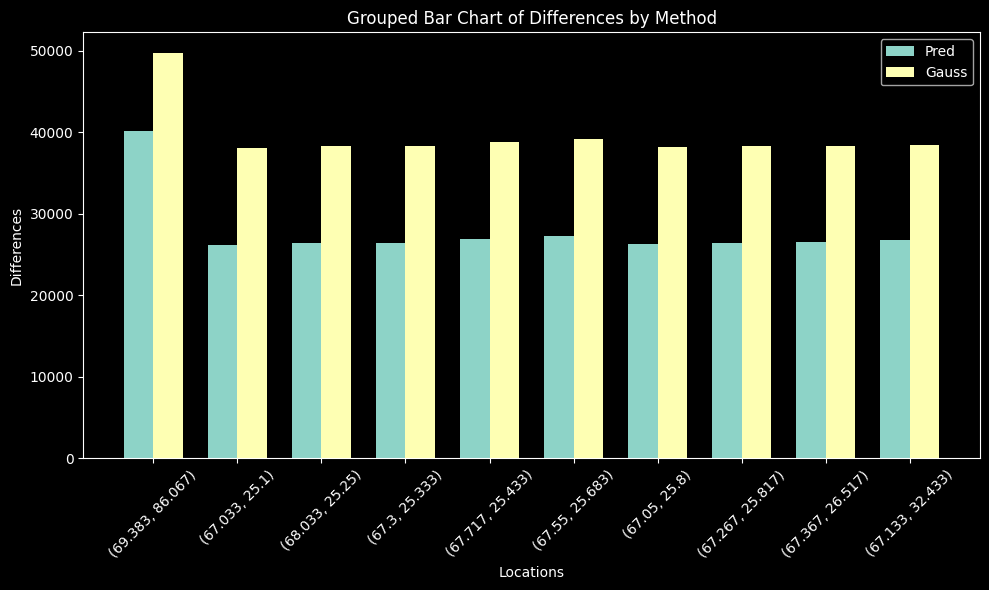

In [1291]:
bar_width = 0.35  # Width of the bars
index = np.arange(len(locs))  # Array of indices for locations

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the figsize if needed
bar1 = ax.bar(index, diffs['pred'], bar_width, label='Pred')
bar2 = ax.bar(index + bar_width, diffs['gauss'], bar_width, label='Gauss')

# Adding labels and title
ax.set_xlabel('Locations')
ax.set_ylabel('Differences')
ax.set_title('Grouped Bar Chart of Differences by Method')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(locs, rotation=45)  # Rotate labels if they are too close
ax.legend()

# Display the chart
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()